We collected paired Xenium data from the same mouse liver. 

In [3]:
import scanpy as sc
import pandas as pd
from scipy import io
from anndata import AnnData
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import sparse
from scipy.spatial import cKDTree
from scipy.stats import mannwhitneyu

In [4]:
adata = sc.read_h5ad('/Users/jamesbolepan/Documents/research_LiverStress_Immune/xenium_manual_extract/xenium_adata.h5ad')
adata

AnnData object with n_obs × n_vars = 723466 × 477
    obs: 'orig.ident', 'nCount_Xenium', 'nFeature_Xenium', 'segmentation_method', 'nCount_BlankCodeword', 'nFeature_BlankCodeword', 'nCount_ControlCodeword', 'nFeature_ControlCodeword', 'nCount_ControlProbe', 'nFeature_ControlProbe', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.3', 'seurat_clusters', 'round1.tier1', 'round1.tier2', 'round1.tier3', 'round1.tier4', 'sample', 'area_mm_2', 'cohort_short', 'cohort_medium', 'cohort_mash_medium', 'cohort_long', 'gender', 'race', 'ethnicity', 'age_at_sample_collection', 'bmi_calculated', 'subject_overview', 'hiv_test', 'hcv_ab', 'h_bc_ab', 'a1', 'a2', 'b1', 'b2', 'c1', 'c2', 'cirrhosis', 'cirrhosis_specify', 'fibrosis', 'meld_score', 'child_score', 'steatosis', 'inflammation', 'transplant_candidate', 'path_report_available', 'hcc', 'esld', 'nash', 'ash', 'diabetes_mellitus', 'hyperlipidemia_or_hypercholesterolemia', 'alcohol_abuse', 'liver_metastases', 'primary_lesion', 'coronary_artery_disease

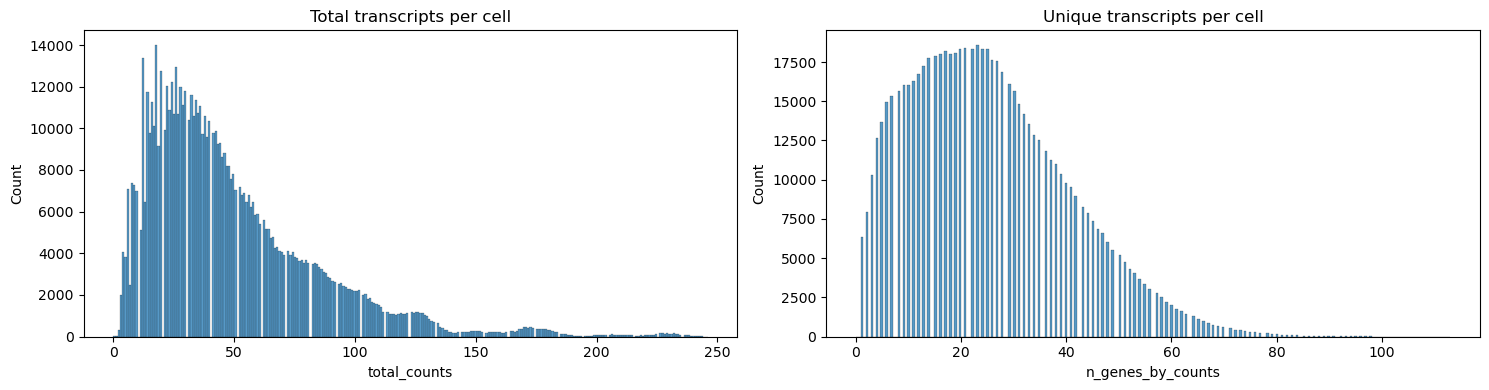

In [5]:
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)
plt.tight_layout()
plt.show()

In [6]:
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)

In [7]:
# Ensure both genes are in your dataset
genes = ["NKG7", "KLRB1"]
assert all(gene in adata.var_names for gene in genes), "One or both genes missing"

# Extract expression values
gene1_expr = adata[:, "NKG7"].X
gene2_expr = adata[:, "KLRB1"].X

# Convert to 1D arrays
if sparse.issparse(gene1_expr): gene1_expr = gene1_expr.toarray().flatten()
else: gene1_expr = np.ravel(gene1_expr)

if sparse.issparse(gene2_expr): gene2_expr = gene2_expr.toarray().flatten()
else: gene2_expr = np.ravel(gene2_expr)

# Expression threshold
threshold = 0.5

# Restrict to high expressers and T/NK cells
target_mask = (
    (gene1_expr > threshold) &
    (gene2_expr > threshold) &
    (adata.obs["round1.tier3"] == "T.Innate").values
)

# Extract cell indices
target_indices = adata.obs_names[target_mask]
print(f"Identified {len(target_indices)} NKG7 KLRB1 T/NK cells")


Identified 3431 NKG7 KLRB1 T/NK cells


In [8]:
# All coordinates
coords = adata.obsm["spatial"]

# Coordinates of target cells
target_coords = coords[adata.obs_names.isin(target_indices)]

# Coordinates of other cells
other_mask = ~adata.obs_names.isin(target_indices)
other_coords = coords[other_mask]
other_labels = adata.obs.loc[other_mask, "round1.tier4"].values

In [9]:
tree = cKDTree(other_coords)

# For each CXCR6+ CD8 cell, find nearest other cell and its type
distances, indices = tree.query(target_coords, k=1)
nearest_types = other_labels[indices]

In [10]:
from collections import Counter
counts = Counter(nearest_types)

# Optional: convert to DataFrame
df = pd.DataFrame.from_dict(counts, orient="index", columns=["nearest_count"])
df["proportion"] = df["nearest_count"] / df["nearest_count"].sum()
df = df.sort_values("nearest_count", ascending=False)
df

,nearest_count,proportion
Hepatocyte.Canonical,1136,0.331099
Kupffer.CD5L+MARCO+,630,0.183620
Stellate.DNASE1L3+CD36+,495,0.144273
Stellate.PDGFRA+HGF+,300,0.087438
T.Innate.KLRB1+NKG7+,261,0.076071
T.CD4.CD69+CTLA+,101,0.029437
Kupffer.MNDA+CLEC4E+,76,0.022151
T.CD8.CXCR6+DUSP2+,67,0.019528
Macrophage.VCAN1+IL1B+,64,0.018653
T.Innate.GNLY+PRF1+,43,0.012533


In [13]:
target_row_metadata = adata.obs[adata.obs_names.isin(target_indices)]
sample_counts = target_row_metadata.groupby(["sample", "cohort_short"]).size().reset_index(name="count")
# drop the rows with count 0
sample_counts = sample_counts[sample_counts["count"] > 0].reset_index(drop=True)
# sort by cohort and sample
sample_counts = sample_counts.sort_values(by=["cohort_short", "sample"]).reset_index(drop=True)
sample_counts

/var/folders/s5/wm1n11sn35z51ccfk1fs07qc0000gn/T/ipykernel_41266/4207783540.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_counts = target_row_metadata.groupby(["sample", "cohort_short"]).size().reset_index(name="count")


,sample,cohort_short,count
0,10-023,Control,184
1,10-027,Control,177
2,10-032,Control,83
3,10-037,Control,387
4,11-00C,Control,342
5,11-025,Control,146
6,11-072,Control,336
7,12-079,Control,155
8,13-095,Control,122
9,10-068,MASH,132


Mann-Whitney U test statistic: 55.0, p-value: 0.21637300805763737


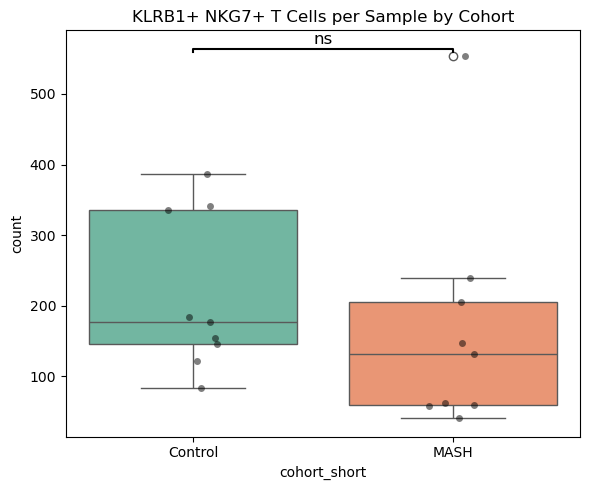

In [15]:
# Perform Mann-Whitney U test
control_counts = sample_counts[sample_counts['cohort_short'] == 'Control']['count']
mash_counts = sample_counts[sample_counts['cohort_short'] == 'MASH']['count']
stat, pval = mannwhitneyu(control_counts, mash_counts)
print(f"Mann-Whitney U test statistic: {stat}, p-value: {pval}")

# Determine significance
if pval < 0.001:
    sig = '***'
elif pval < 0.01:
    sig = '**'
elif pval < 0.05:
    sig = '*'
else:
    sig = 'ns'

# Plot
plt.figure(figsize=(6, 5))
ax = sns.boxplot(data=sample_counts, x='cohort_short', y='count', hue = "cohort_short", palette='Set2')
sns.stripplot(data=sample_counts, x='cohort_short', y='count', color='black', alpha=0.5, jitter=True)

y = max(sample_counts['count']) + 10
ax.plot([0, 0, 1, 1], [y-5, y, y, y-5], lw=1.5, c='black')
ax.text(0.5, y + 2, sig, ha='center', va='bottom', fontsize=12)

plt.title('KLRB1+ NKG7+ T Cells per Sample by Cohort')
plt.tight_layout()
plt.show()